In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/bruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Funções auxiliares

In [2]:
def get_matrix(n_labels, topics, chooseLabel=False, list_labels=[]):
    n_docs = len(topics)

    if chooseLabel:
        labels = list_labels
        aux = {}
        for i, j in enumerate(list_labels):
            aux[j] = i
    else:
        labelfreq, aux, _ = get_frequency(topics)
        labels = [i[0] for i in labelfreq][:n_labels-1]

    labels.append('outros')

    ind_matrix = np.zeros(shape=(n_docs, n_labels),
                          dtype=np.int8)

    for i in range(n_docs):
        achou = False
        for j in topics[i]:
            if j in labels:
                ind_matrix[i][aux[j]] = 1
                achou = True
        if not achou:
            ind_matrix[i][-1] = 1

    return ind_matrix, labels

def plot(scores, labels):
    """Plot scores of best models in a barplot based on f1 score"""
    n_labels = len(labels)

    aux = pd.DataFrame(index=[labels] ,columns=['precision', 'recall', 'f1-score', 'qnt'], dtype=float)
    
    for j, i in enumerate(scores):
        if j == n_labels: break
        scores[i].pop('support', None)
        aux.iloc[j] = scores[i]
    
    # aux.set_index(labels, inplace=True)
    print(aux)

    aux.sort_values('f1-score', ascending=False).plot(
        kind='bar',
        figsize=(12,5),
        title='Score of Highest Performing Models',
        ylabel='score',
        colormap='plasma'
    )
    plt.ylim(bottom=0)
    plt.show()

def get_frequency(topics):

    lista = topics.to_list()

    d = dict()
    total = 0
    for x in lista:
        for y in x:
            if y not in d:
                d[y] = 1
            else:   
                d[y] += 1

    labelfreq = sorted(d.items(), key=lambda item:item[1], reverse=True)
    for x,y in labelfreq:
        total += y
    
    aux = {}
    for i, j in enumerate(labelfreq):
        aux[j[0]] = i

    return labelfreq, aux, total

def get_scores(Y_test, predict, labels, topics):
    scores = classification_report(Y_test, predict, target_names=labels, output_dict=True)

    labelfreq, aux, total = get_frequency(topics)

    soma = 0
    for i in labels[:-1]:
        scores[i]['qnt'] = (labelfreq[aux[i]][1]/total)

        soma += labelfreq[aux[i]][1]

    scores['outros']['qnt'] = ((total-soma)/total)

    somap = 0.0
    for i in labels[:-1]:
        somap += scores[i]['qnt']
    
    return scores

## importando os dados

In [3]:
data = pd.read_csv('data.csv')
data.fillna('', inplace=True)
data.head()

,contest,problem_name,problem_statement,problem_tags
0,325,A,You are given n rectangles. The corners of rec...,"implementation,*1500"
1,325,B,Daniel is organizing a football tournament. He...,"binarysearch,math,*1800"
2,325,C,Piegirl has found a monster and a book about m...,"dfsandsimilar,graphs,shortestpaths,*2600"
3,325,D,"In a far away land, there exists a planet shap...","dsu,*2900"
4,325,E,Piegirl found the red button. You have one las...,"combinatorics,dfsandsimilar,dsu,graphs,greedy,..."


## pre-processando

In [4]:
sw = stopwords.words('english')
sw += ['input', 'output', 'th', 'print', 'test', 'case', 'line']
lemma = WordNetLemmatizer()
text = data.problem_statement

# Problem_statement
print(text[8341][:100])
print('------------')
text = text.apply(lambda x: re.sub(r'\${1,3}(.*?)\${1,3}', ' ',x))
text = text.apply(lambda x: re.sub(r'(?:\\)[a-zA-Z]+', ' ',x))
text = text.apply(lambda x: re.sub(r'\{(.*?)\}', ' ',x))
text = text.apply(lambda x: re.sub(r"[\,|\.|\(|\)|\!|\?|\:|\']",' ',x)) # removendo caracteres especiais
text = text.apply(lambda x: [i for i in x.split() if i.lower() not in sw]) # removendo stop-words
text = text.apply(lambda x: ' '.join([lemma.lemmatize(i) for i in x])) # lemmatizando todo

# Topics
topics = data.problem_tags
topics = topics.apply(lambda x: re.sub('[*][0-9]+','',x)) # remove os ratings *800 etc
topics = topics.apply(lambda x: [i for i in x.split(',') if i != '']) # tira strings vazias

print(text[8341][:100])
print(topics[0])


At first, let's define function $$$f(x)$$$ as follows: $$$$$$ \begin{matrix} f(x) & = & \left\{ \beg
------------
first let define function follows f x & = & \ & x \\ x - 1 & see choose value apply function apply e
['implementation']


## coletando topicos

In [5]:
labelfreq, aux, total = get_frequency(topics)

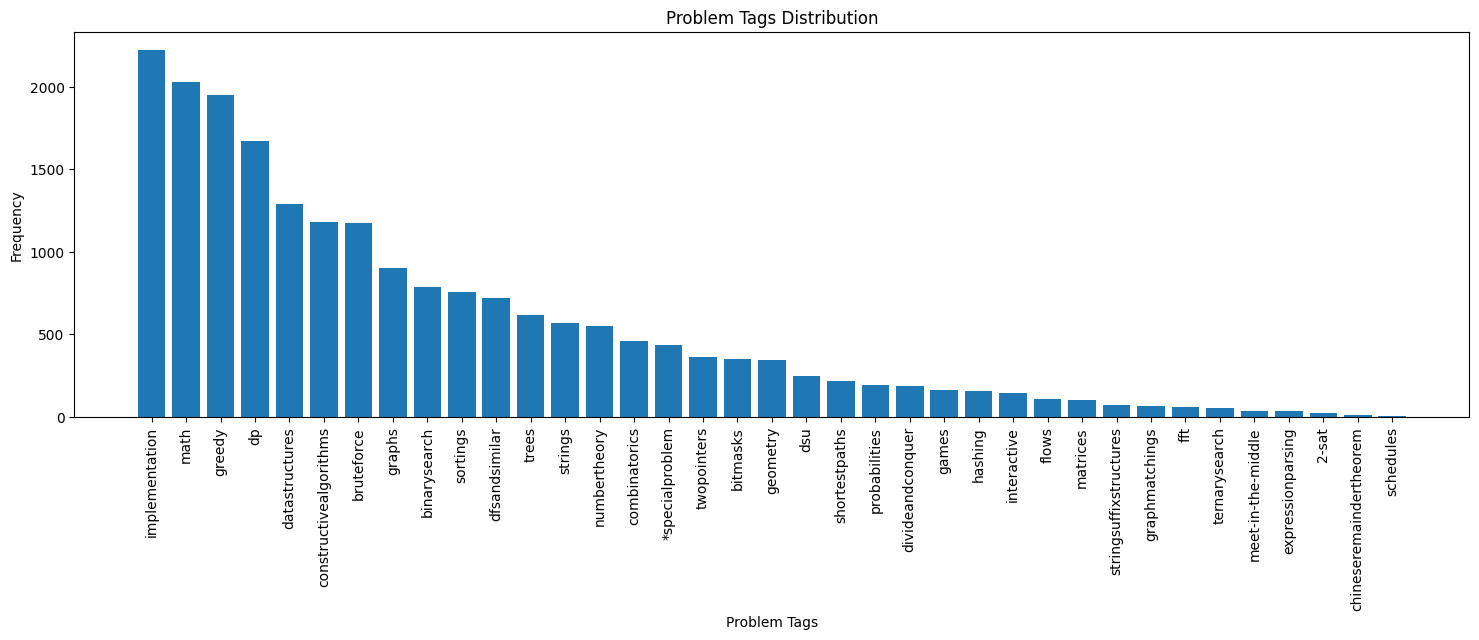

In [6]:
plt.subplots(figsize=(18,5))
plt.xlabel("Problem Tags")
plt.ylabel("Frequency")
plt.title("Problem Tags Distribution")
plt.bar(range(len(labelfreq)), [x[1] for x in labelfreq])
plt.xticks(range(len(labelfreq)), [x[0] for x in labelfreq], rotation='vertical')
plt.show()

## definindo pipeline

In [7]:
# parametros

ngram_range = (1,3)
max_df = 0.9
min_df = 4

norm = 'l2'
smooth_idf = True

In [8]:
pipe = Pipeline([('vec', CountVectorizer(ngram_range=ngram_range,
                                         max_df=max_df,
                                         min_df=min_df)),
                 ('tfidf', TfidfTransformer(norm=norm,
                                            smooth_idf=smooth_idf)),
                 ('svm', OneVsRestClassifier(LinearSVC()))
                ])

## teste 1

In [9]:
n_labels = 37

Y, labels = get_matrix(n_labels, topics)
X_train, X_test, Y_train, Y_test = train_test_split(text, Y, test_size=0.25, random_state=0)

pipe.fit(X_train, Y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.9, min_df=4, ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('svm', OneVsRestClassifier(estimator=LinearSVC()))])

/home/bruno/Desktop/PIBIC/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruno/Desktop/PIBIC/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score       qnt
implementation            0.485564  0.357143  0.411568  0.109555
math                      0.637195  0.417166  0.504222  0.100035
greedy                    0.606349  0.384306  0.470443  0.096187
dp                        0.572650  0.322115  0.412308  0.082524
datastructures            0.653846  0.394040  0.491736  0.063631
constructivealgorithms    0.676259  0.323024  0.437209  0.058255
bruteforce                0.383562  0.098592  0.156863  0.057860
graphs                    0.814815  0.504587  0.623229  0.044443
binarysearch              0.576271  0.163462  0.254682  0.038771
sortings                  0.653061  0.202532  0.309179  0.037439
dfsandsimilar             0.580000  0.282927  0.380328  0.035417
trees                     0.754545  0.546053  0.633588  0.030435
strings                   0.721649  0.522388  0.606061  0.028215
numbertheory              0.759259  0.303704  0.433862  0.027327
combinatorics            

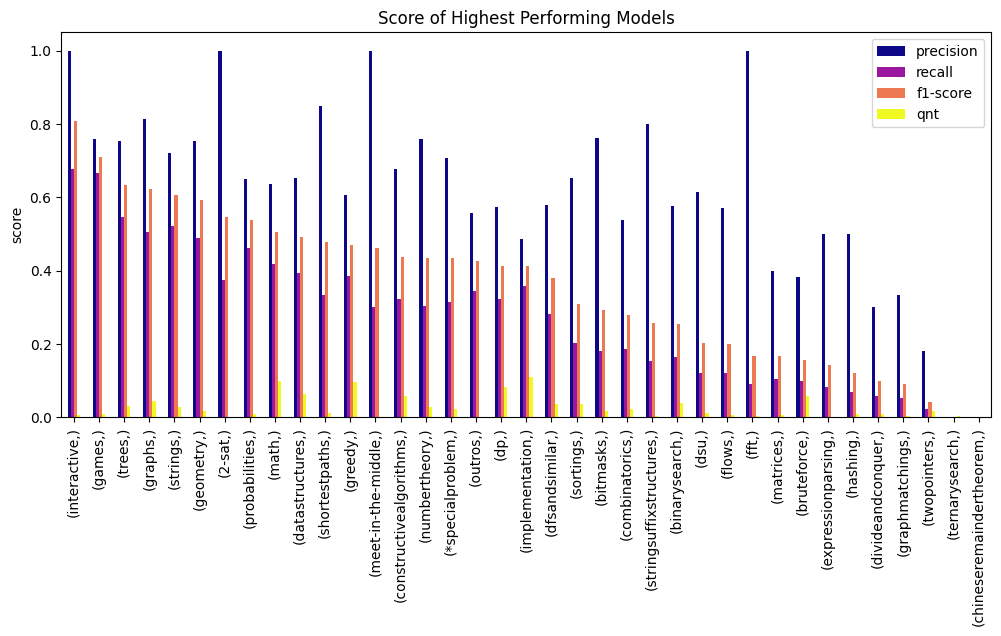

In [10]:
predict = pipe.predict(X_test)
scores = get_scores(Y_test, predict, labels, topics)
plot(scores, labels)

## teste 2

In [11]:
n_labels = 2

Y, labels = get_matrix(n_labels, topics, True, ['interactive'])
X_train, X_test, Y_train, Y_test = train_test_split(text, Y, test_size=0.3, random_state=0)
pipe.fit(X_train, Y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.9, min_df=4, ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('svm', OneVsRestClassifier(estimator=LinearSVC()))])

             precision    recall  f1-score       qnt
interactive   1.000000  0.722222  0.838710  0.007152
outros        0.995963  1.000000  0.997977  0.992848


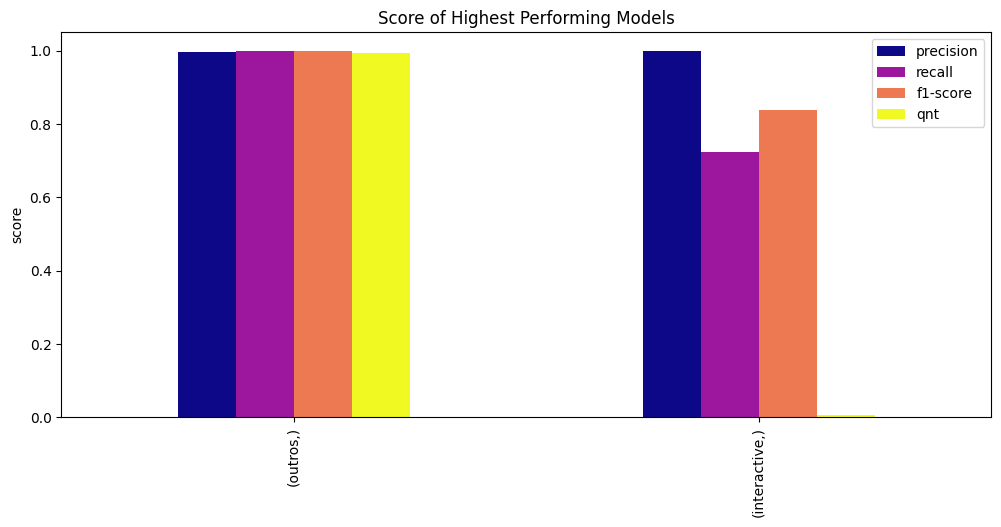

In [12]:
predict = pipe.predict(X_test)
scores = get_scores(Y_test, predict, labels, topics)
plot(scores, labels)